In [1]:
!gdown 1mU--DNhy8pWMTljj7jI3FvJwRYRHwAq5
!gdown 1yt9RDch0ZT9gtTfEBQLFFhGPw3PSOEh0
!gdown 13XpLuVuxI6ekdEf5UElKH_IMWrK8wZU1


Downloading...
From: https://drive.google.com/uc?id=1mU--DNhy8pWMTljj7jI3FvJwRYRHwAq5
To: /content/content_img.jpg
100% 1.15M/1.15M [00:00<00:00, 80.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yt9RDch0ZT9gtTfEBQLFFhGPw3PSOEh0
To: /content/style_img.jpg
100% 517k/517k [00:00<00:00, 25.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=13XpLuVuxI6ekdEf5UElKH_IMWrK8wZU1
To: /content/style_img2.jpg
100% 1.02M/1.02M [00:00<00:00, 24.5MB/s]


## 1. Imports

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torch
import torch.nn as nn

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Data

In [5]:
from PIL import Image
import torchvision.transforms as transforms

imsize = 256

img_transforms = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()
])


In [6]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = img_transforms(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img1 = image_loader("style_img.jpg")
style_img2 = image_loader("style_img2.jpg")
content_img = image_loader("content_img.jpg")

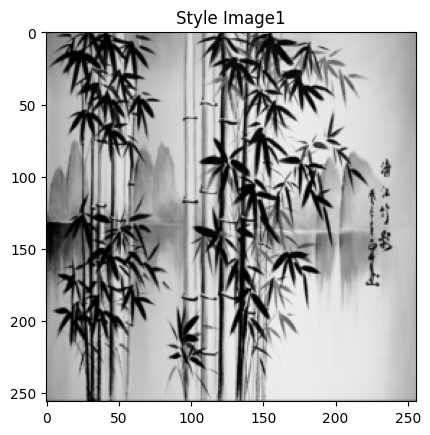

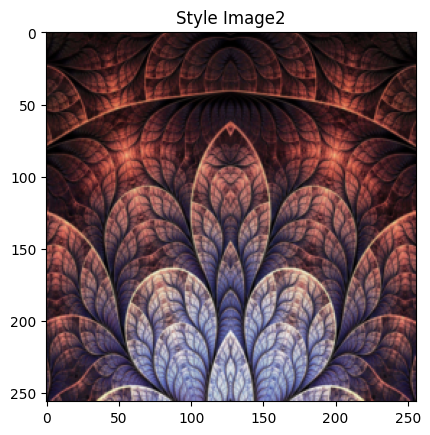

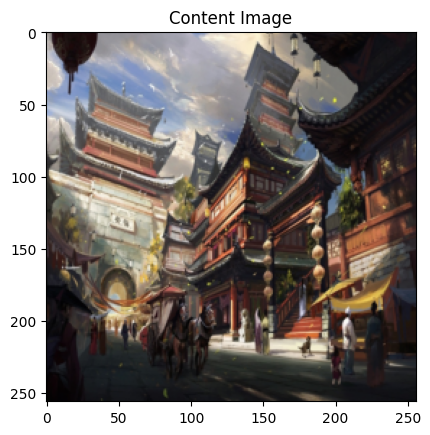

In [7]:
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


plt.figure()
imshow(style_img1, title='Style Image1')

plt.figure()
imshow(style_img2, title='Style Image2')

plt.figure()
imshow(content_img, title='Content Image')

## 3. Loss Functions

### 3.1 Content Loss

In [8]:
content_weight = 1
ContentLoss = nn.MSELoss()

### 3.2 Style Loss

In [9]:
def gram_matrix(tensor):
    a, b, c, d = tensor.size()
    tensor = tensor.view(a * b, c * d)
    G = torch.mm(tensor, tensor.t())
    return G.div(a * b * c * d)

style_weight = 1e6
StyleLoss = nn.MSELoss()

## 3. Model

In [10]:
from torchvision.models import vgg19, VGG19_Weights

VGG19_pretrained = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()
VGG19_pretrained.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 175MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [11]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(torch.tensor([0.485, 0.456, 0.406]).to(device)).view(-1, 1, 1)
        self.std = torch.tensor(torch.tensor([0.229, 0.224, 0.225]).to(device)).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

normalization = Normalization().to(device)

<ipython-input-11-74401423e966>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(torch.tensor([0.485, 0.456, 0.406]).to(device)).view(-1, 1, 1)
<ipython-input-11-74401423e966>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(torch.tensor([0.229, 0.224, 0.225]).to(device)).view(-1, 1, 1)


In [12]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2',
                'conv_3', 'conv_4',
                'conv_5']

In [13]:
def get_features(pretrained_model, image):
    layers = {
        '0': 'conv_1',
        '5': 'conv_2',
        '10': 'conv_3',
        '19': 'conv_4',
        '28': 'conv_5'
    }
    features = {}
    x = image
    x = normalization(x)
    for name, pretrained_layer in pretrained_model._modules.items():
        x = pretrained_layer(x)
        if name in layers:
            features[layers[name]] = x
    return features


In [14]:
def get_dual_style(style_features1, style_features2, style_layers):
    final_style_features = {}
    for layer in style_layers:
        sf1 = style_features1[layer]
        sf2 = style_features2[layer]
        ##############################YOUR CODE HERE############################
        # 1. Calculate the size of the first portion of sf1 to be used.
        #    This is a quarter of the number of channels (dimension 1).
        # 2. Concatenate the first portion of sf1 with the second portion of sf2
        # along the channel dimension.
        #    - The first portion of sf1 should contain the first 'sf1_size' channels.
        #    - The second portion of sf2 should contain the channels starting
        #      from 'sf1_size' to the end.
        ########################################################################
        sf1_size = int(sf1.size()[1] / 4)

        final_style_features[layer] = torch.concatenate([
            sf1[:, :sf1_size, :, :],
            sf2[:, sf1_size:, :, :]
        ], dim=1)
    return final_style_features

In [15]:
content_features = get_features(VGG19_pretrained, content_img)
style_features1 = get_features(VGG19_pretrained, style_img1)
style_features2 = get_features(VGG19_pretrained, style_img2)
final_style_features = get_dual_style(style_features1, style_features2, style_layers)

## 4. Training

In [16]:
import torch.optim as optim

target_img = content_img.clone().requires_grad_(True).to(device)
optimizer = optim.Adam([target_img], lr=0.02)


In [17]:
def style_tranfer_(model, optimizer, target_img,
                   content_features, style_features,
                   style_layers, content_weight, style_weight):

    optimizer.zero_grad()
    with torch.no_grad():
        target_img.clamp_(0, 1)
    target_features = get_features(model, target_img)

    content_loss = ContentLoss(content_features['conv_4'],
                               target_features['conv_4'])

    style_loss = 0
    for layer in style_layers:
        target_gram = gram_matrix(target_features[layer])
        style_gram = gram_matrix(style_features[layer])
        style_loss += StyleLoss(style_gram, target_gram)

    total_loss = content_loss*content_weight + style_loss*style_weight
    total_loss.backward(retain_graph=True)
    optimizer.step()
    return total_loss, content_loss, style_loss

In [18]:
STEPS = 500

for step in range(STEPS):
    optimizer.zero_grad()
    with torch.no_grad():
        target_img.clamp_(0, 1)

    total_loss, content_loss, style_loss = style_tranfer_(VGG19_pretrained, optimizer, target_img,
                                                           content_features, final_style_features,
                                                           style_layers, content_weight, style_weight)
    if step % 100 == 99:
        print(f"Epoch [{step+1}/{STEPS}] Total loss: {total_loss.item():.6f} - \
                Content loss: {content_loss.item():.6f} - Style loss: {style_loss.item():.6f}")

    with torch.no_grad():
        target_img.clamp_(0, 1)

Epoch [100/500] Total loss: 100.458832 -                 Content loss: 23.219707 - Style loss: 0.000077
Epoch [200/500] Total loss: 94.862091 -                 Content loss: 22.965984 - Style loss: 0.000072
Epoch [300/500] Total loss: 93.003151 -                 Content loss: 23.070908 - Style loss: 0.000070
Epoch [400/500] Total loss: 91.573174 -                 Content loss: 23.170944 - Style loss: 0.000068
Epoch [500/500] Total loss: 90.847923 -                 Content loss: 22.737185 - Style loss: 0.000068


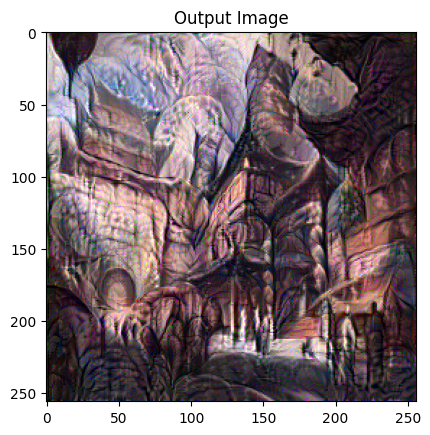

In [19]:
plt.figure()
imshow(target_img.detach(), title='Output Image')
plt.show()